In [1]:
print("Importing misc libraries")
import sys
import os
import torch
#import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

print("Updating sys.path")
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
models_path = Path.cwd().parent
if str(models_path) not in sys.path:
    sys.path.append(str(models_path))
    
print("Importing torch libraries")
from torch.utils.data import DataLoader
import multiprocessing
from torchvision.transforms import ToTensor
import torch
    
print("Importing deeplab lib")
import importlib
import deeplabv3.Deeplabv3 as d
importlib.reload(d)

print("Importing dataset lib")
from dataset.IntersectionDataset import IntersectionDataset, IntersectionDataset2, IntersectionDatasetClasses, custom_collate_fn
import loss.loss_lib as ll
importlib.reload(ll)
import loss.topo_lib as tl
importlib.reload(tl)

# dataset_dir = "../../dataset/dataset/train"
# img_transform = ToTensor()
# path_transform = ToTensor()
# dataset_train = IntersectionDatasetClasses(root_dir=dataset_dir, 
#                                     transform=img_transform,
#                                     path_transform=path_transform)

dataset_dir = "../../dataset/dataset/test"
img_transform = ToTensor()
path_transform = ToTensor()
dataset_test = IntersectionDatasetClasses(root_dir=dataset_dir,
                                   transform=img_transform,
                                   path_transform=path_transform)
# print(len(dataset_train))
print(len(dataset_test))

num_workers = multiprocessing.cpu_count()
b = 1

# train_dataloader = DataLoader(dataset_train, batch_size=b, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size=b, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True, collate_fn=custom_collate_fn)

Importing misc libraries
Updating sys.path
Importing torch libraries
Importing deeplab lib
Importing dataset lib
32


In [2]:
ckpt_path = "ckpt/c_deeplab_04_23_50_ce-topo_adamw_exp.pth"
ckpt = torch.load(ckpt_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = d.DeepLabV3().to(device)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()
print()

(400, 400)


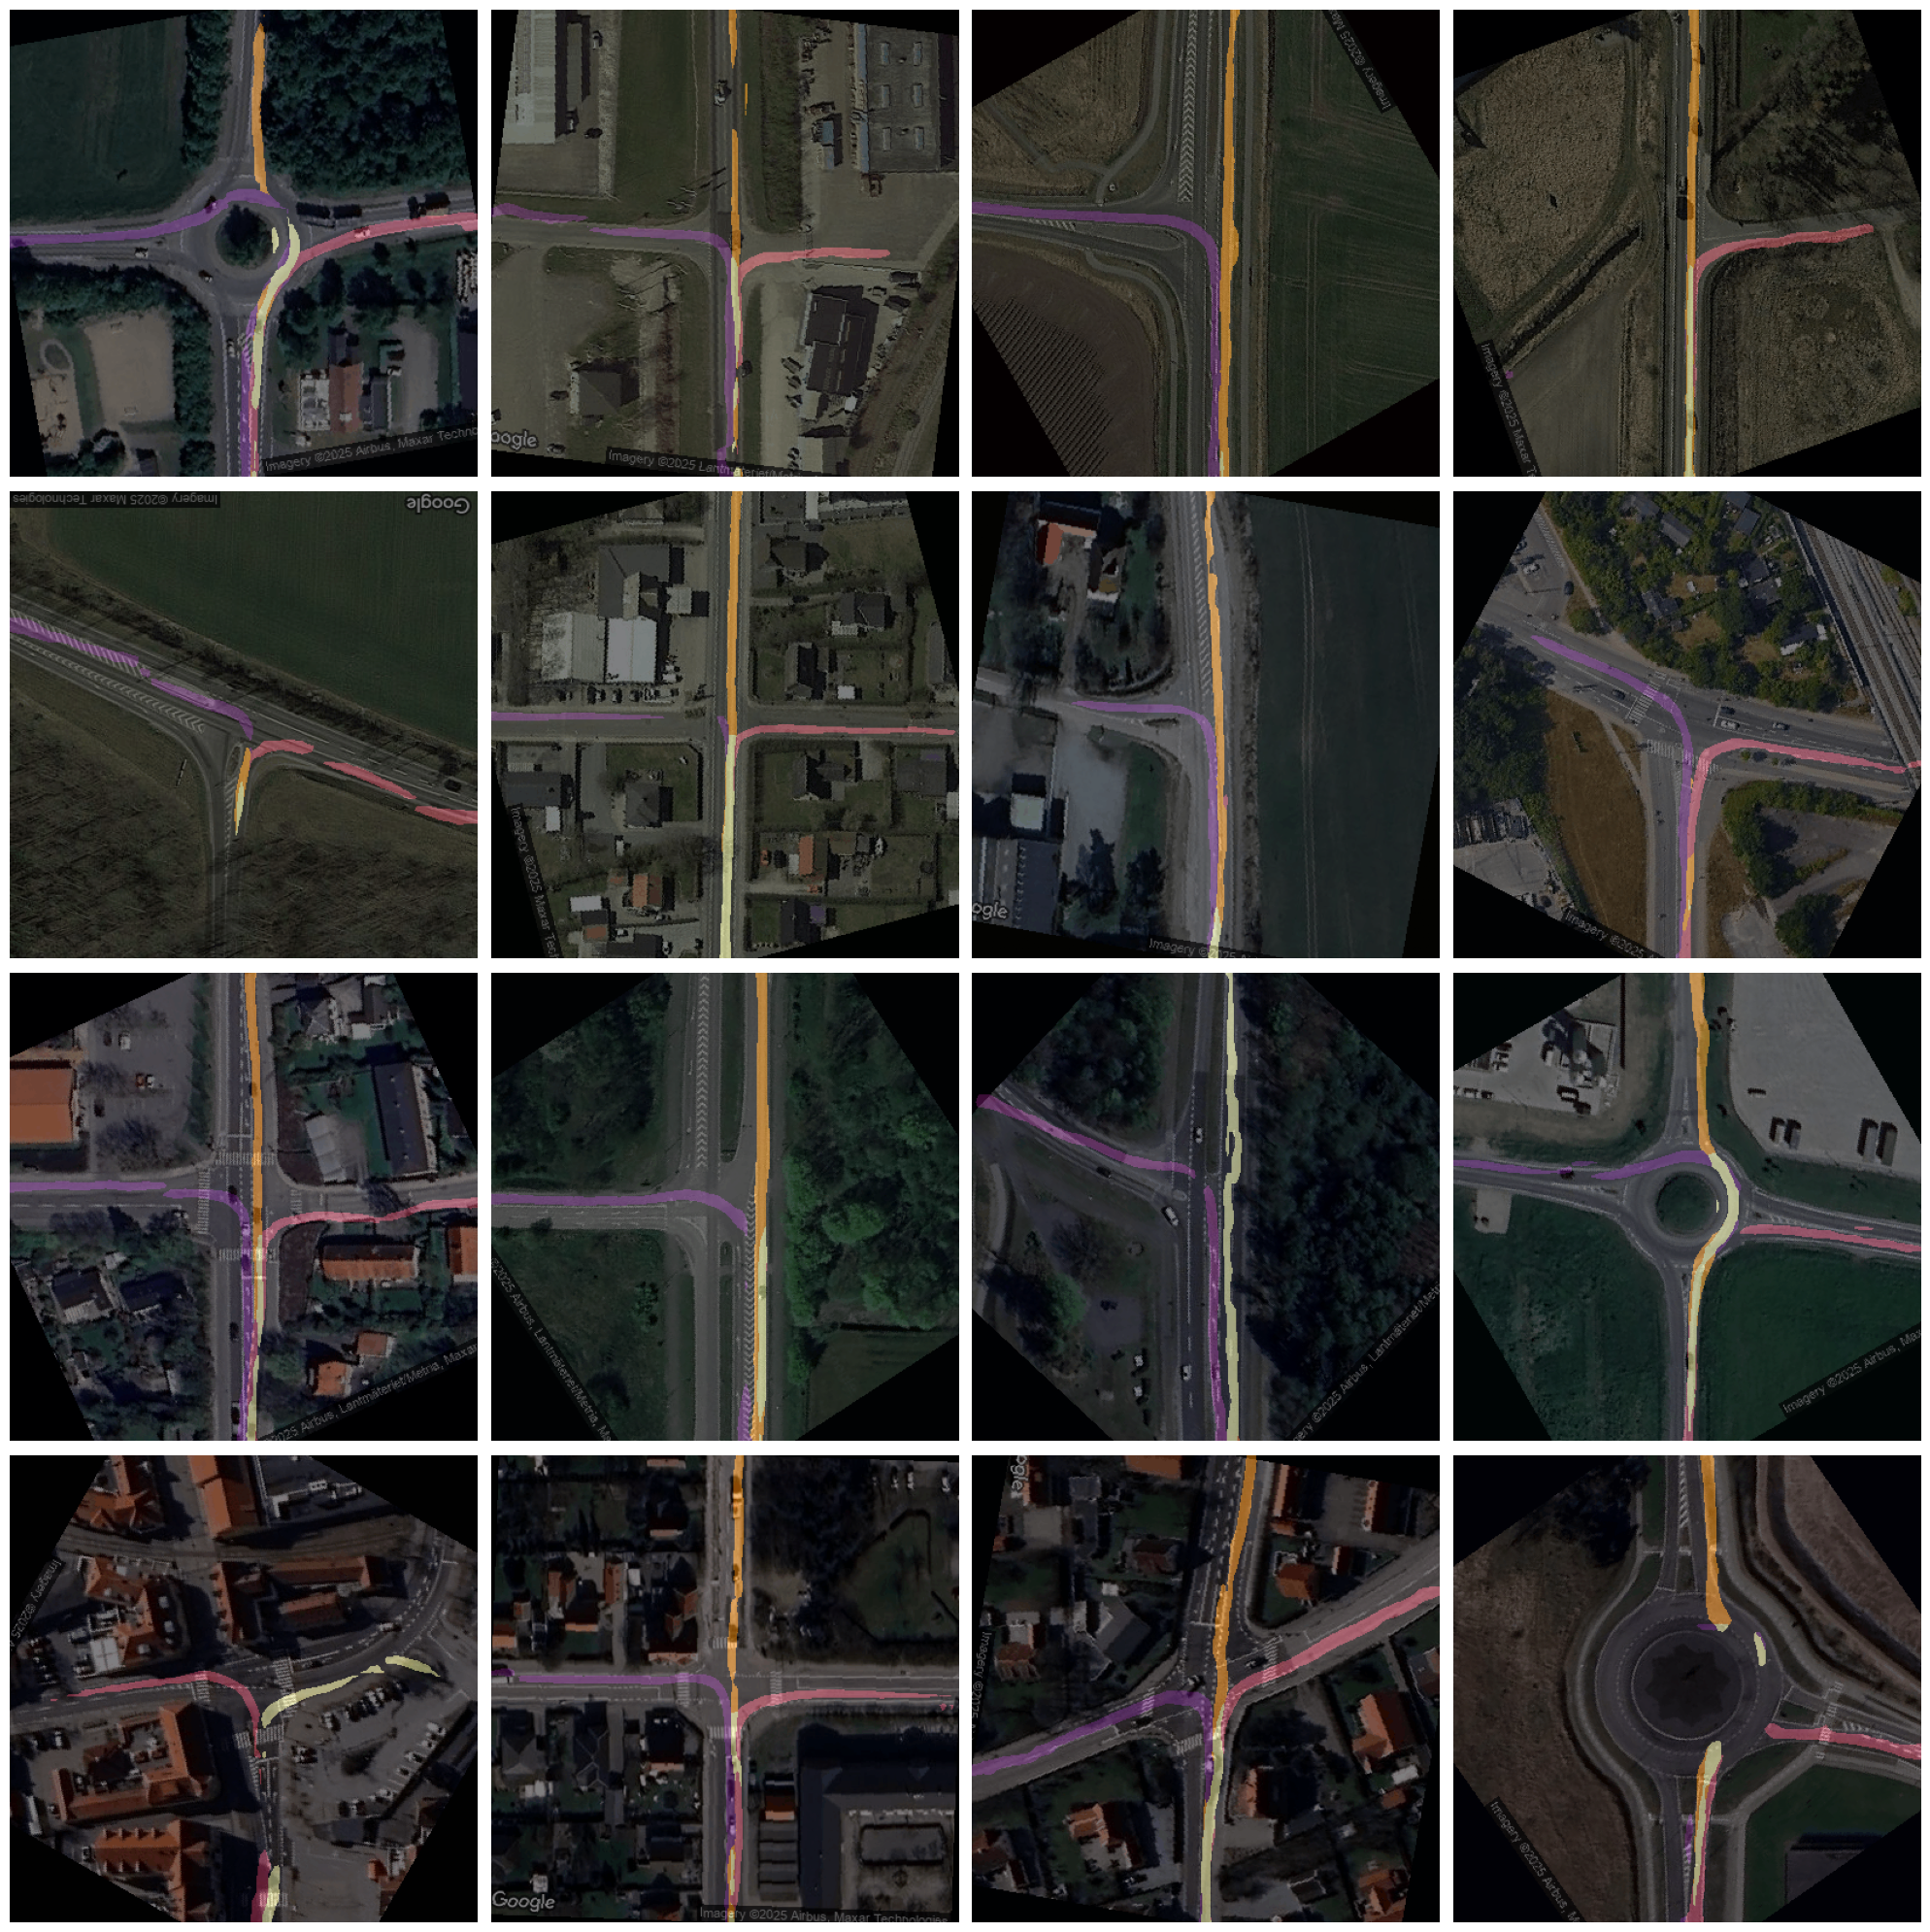

In [ ]:
rows, cols = 4, 4
rc_ratio = rows / cols
if rc_ratio > 1:
    fig_width = 20
    fig_height = fig_width / rc_ratio
else:
    fig_height = 20
    fig_width = fig_height * rc_ratio

fig = plt.figure(figsize=(fig_width, fig_height))

i = 0
while i < rows * cols:
    satellite = test_dataloader.dataset[i]['satellite'].to(device)
    
    i += 1
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(satellite.cpu().numpy().transpose(1, 2, 0))
    plt.axis('off')
    
    output = model(satellite.unsqueeze(0))
    #print(output.shape)
    output = torch.argmax(output, dim=1)
    output = output.squeeze(0).cpu().numpy()
    
    #i += 1
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(output, cmap='inferno', alpha=0.5)
    plt.axis('off')

    #i += 1
    
fig.tight_layout()

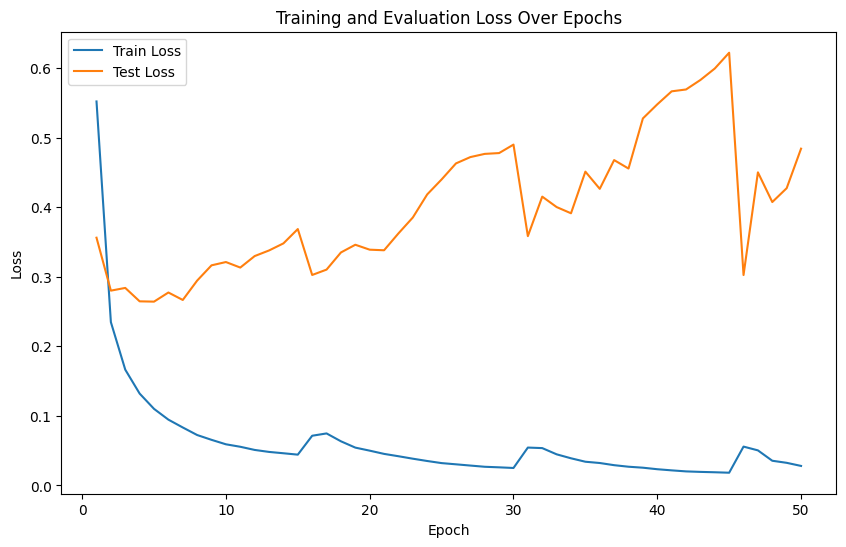

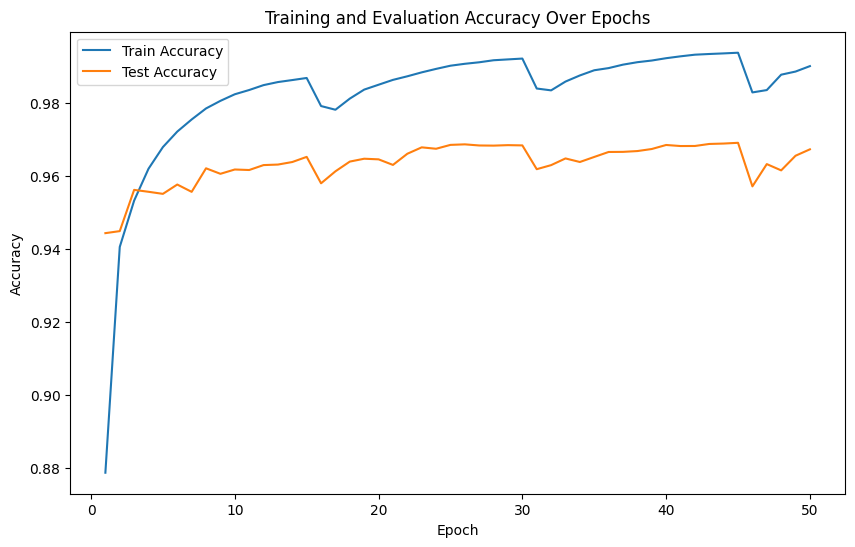

In [4]:
#ckpt_path = "ckpt/c_04_10_15_ce_cos.pth"
#ckpt = torch.load(ckpt_path)

n_epochs = len(ckpt['train_losses'])
train_losses = ckpt['train_losses']
test_losses = ckpt['test_losses']
train_accuracies = ckpt['train_accuracies']
test_accuracies = ckpt['test_accuracies']
# Plotting the loss graphs
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, n_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
plt.show()

# Plotting the accuracy graphs
plt.figure(figsize=(10, 6))
train_accuracies_normalized = [acc / (400**2) for acc in train_accuracies]
test_accuracies_normalized = [acc / (400**2) for acc in test_accuracies]

plt.plot(range(1, n_epochs + 1), train_accuracies_normalized, label="Train Accuracy")
plt.plot(range(1, n_epochs + 1), test_accuracies_normalized, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Evaluation Accuracy Over Epochs")
plt.legend()
plt.show()

In [4]:
l_topo = tl.TopologyLoss().to(device)

satellite = test_dataloader.dataset[0]['satellite'].to(device)

output = model(satellite.unsqueeze(0))

In [12]:
L_topo = l_topo(output)

In [13]:
L_topo.item()

2.3885498046875

In [14]:
L_topo.backward()

(np.float64(-0.5), np.float64(399.5), np.float64(399.5), np.float64(-0.5))

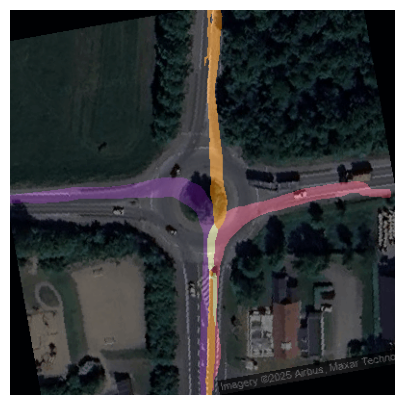

In [6]:
fig = plt.figure(figsize=(5, 5))
rows, cols = 1, 1
i = 1
fig.add_subplot(rows, cols, i)
plt.imshow(satellite.cpu().numpy().transpose(1, 2, 0))
plt.axis('off')

output = model(satellite.unsqueeze(0))
#print(output.shape)
output = torch.argmax(output, dim=1)
output = output.squeeze(0).cpu().numpy()

#i += 1

fig.add_subplot(rows, cols, i)
plt.imshow(output, cmap='inferno', alpha=0.5)
plt.axis('off')

In [16]:
logits = torch.zeros(1, 2, 32, 32)
logits[:,1, 4:12, 4:12]  = 6.0
logits[:,1,18:26,18:26]  = 6.0
logits.requires_grad_()

loss_layer = tl.TopologyLoss(img_size=(32,32), smooth_sigma=None, min_pers=0)
print(loss_layer(logits))          #  →  tensor(~2., grad_fn=...)
loss_layer(logits).backward()
print(logits.grad.abs().sum()) 

tensor(0.2475, grad_fn=<DivBackward0>)
tensor(0.5024)


In [ ]:
model.eval()                                   # ① freeze BN stats
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

for step in range(100):
    opt.zero_grad()
    logits = model(satellite.unsqueeze(0))                    # sat_img shape [1,C,H,W]
    loss   = l_topo(logits)                    # topology loss only
    loss.backward()
    opt.step()

    if step % 10 == 0 or step == 0:
        print(f"[{step:3d}] topo-loss = {loss.item():.4f}")

In [ ]:
def alpha(epoch, alpha_hi = 0.95, alpha_lo = 0.55, T_warm = 50, N_epochs = 500):
    if epoch < T_warm:
        return alpha_hi
    r = (epoch - T_warm) / max(1, N_epochs - T_warm)
    return alpha_hi - (alpha_hi - alpha_lo) * r